In [2]:
from torch.backends.mkl import verbose
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries


## Read electricity data

In [40]:
electricity_consumption = pd.read_csv("../WeatherPreprocessing/WeatherBusinessResidential.csv")
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.002,311.724
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.184,337.730
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.174,348.859
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.551,452.473


In [41]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

<Axes: xlabel='Date'>

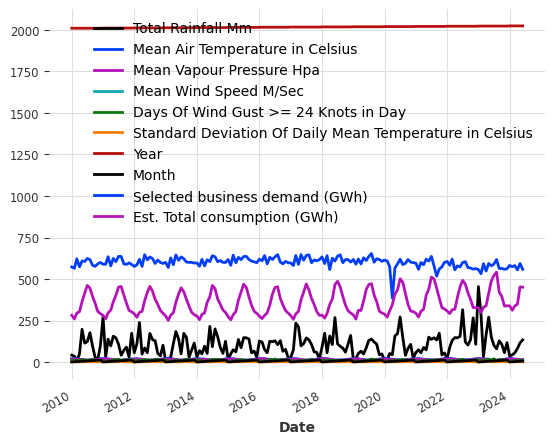

In [42]:
ts.plot()

<Axes: xlabel='Date'>

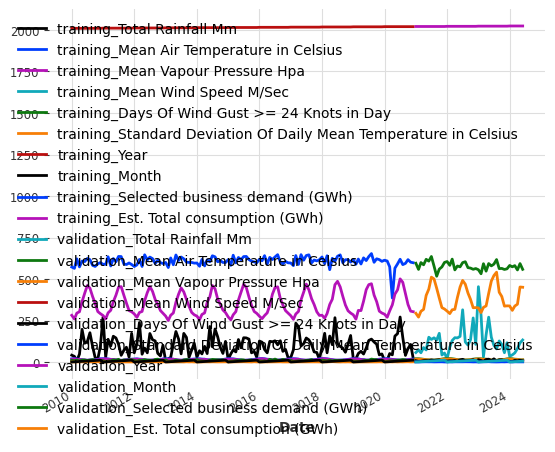

In [105]:
# training and validation split
train, val = ts.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')

## Preprocessing

In [106]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mae, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split Timeseries into target and past covariates
train_target = train_transformed['Est. Total consumption (GWh)']
val_target = val_transformed['Est. Total consumption (GWh)']
train_past_cov = train_transformed[['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']]
val_past_cov = val_transformed[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']]

# replace missing value with the mean of column
train_past_cov = train_past_cov.pd_dataframe()
train_past_cov = train_past_cov.apply(lambda col: col.fillna(col.mean()))
train_past_cov = TimeSeries.from_dataframe(train_past_cov)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model training and testing

In [7]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [112]:
model_lstm = BlockRNNModel(
    model="GRU",

    n_rnn_layers=2,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_LSTM",
    log_tensorboard=True,
    input_chunk_length=36,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=42
)

model_lstm.fit( train_target,
   
    verbose=False)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=25, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.0, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_LSTM, log_tensorboard=True, input_chunk_length=36, save_checkpoints=True, force_reset=True, output_chunk_length=42)

Predicting: |          | 0/? [00:00<?, ?it/s]

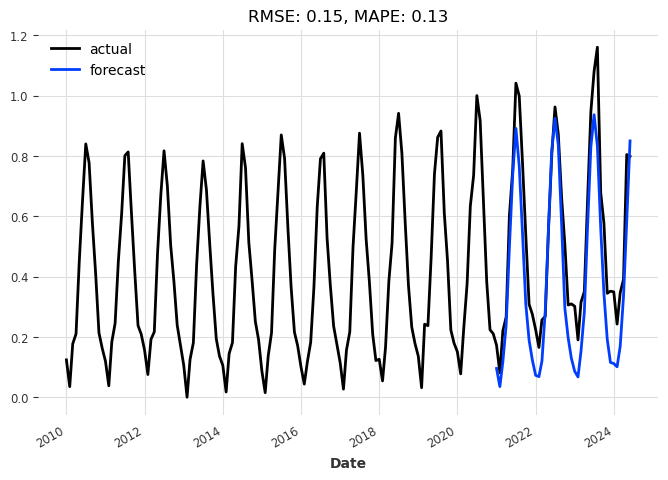

In [115]:
def eval_model(model):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    series_transformed['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series['Est. Total consumption (GWh)'].plot(label="forecast")
    plt.title("RMSE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target, pred_series), mae(val_target, pred_series)))
    plt.legend()
    return pred_series

pred_series_transformed = eval_model(model_lstm)

# Mean Absolute Percentage Error

In [16]:
val_transformed.pd_dataframe()

component,Est. Total consumption (GWh)
Period start,
2021-01-01,0.172382
2021-02-01,0.080858
2021-03-01,0.220478
2021-04-01,0.266054
2021-05-01,0.601850
2021-06-01,0.754546
2021-07-01,1.041391
2021-08-01,0.998559
2021-09-01,0.773856


In [17]:
pred_series_transformed.pd_dataframe()

component,Est. Total consumption (GWh)
Period start,
2021-01-01,0.122642
2021-02-01,0.082756
2021-03-01,0.188650
2021-04-01,0.347625
2021-05-01,0.543134
2021-06-01,0.799389
2021-07-01,0.950581
2021-08-01,0.847759
2021-09-01,0.622775


In [ ]:
# check seasonablity
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)